# 05. 어택 명확도 기반 타격 레이어링 (Onset Clarity)

이벤트별 **Attack Time (10% → 90% 도달 시간)**을 측정하여 타격의 또렷함(Clarity)을 수치화합니다.

In [17]:
import sys
import os
import shutil
import json

# 프로젝트 루트를 경로에 추가
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import uniform_filter1d, median_filter

# 한글 폰트 설정 (macOS 기본 폰트 사용)
plt.rcParams['font.family'] = ['AppleGothic', 'Apple SD Gothic Neo', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print(f"프로젝트 루트: {project_root}")
print(f"Librosa 버전: {librosa.__version__}")

프로젝트 루트: /Users/laxogud/MADCAMP/W4/music-anaylzer
Librosa 버전: 0.11.0


In [18]:
# 입력 오디오 경로 (01_energy와 동일)
# audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'sample_drum_basic_60.mp3')
# audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'stems', 'htdemucs', 'sample_ropes_short', 'drums.wav')
audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'sample_ropes_short.mp3')

if os.path.exists(audio_path):
    y, sr = librosa.load(audio_path)
    duration = len(y) / sr
    print(f"파일: {os.path.basename(audio_path)}")
    print(f"샘플링 레이트: {sr} Hz, 길이: {duration:.2f} 초")
else:
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {audio_path}")

파일: sample_ropes_short.mp3
샘플링 레이트: 22050 Hz, 길이: 31.11 초


In [19]:
# Onset 검출 (01_energy와 파라미터 동일하게 유지)
hop_length = 256
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
onset_frames = librosa.onset.onset_detect(
    onset_envelope=onset_env, sr=sr, hop_length=hop_length,
    delta=0.07, wait=4, backtrack=False,
)
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
strengths = onset_env[onset_frames]

# BPM 추정
tempo, _ = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
bpm = float(tempo) if hasattr(tempo, "item") else float(tempo)

print(f"검출된 타격점 수: {len(onset_times)}")
print(f"추정 BPM: {bpm:.1f}")

검출된 타격점 수: 113
추정 BPM: 89.1


/var/folders/6c/v395vbb952ggdz819m67vbg80000gn/T/ipykernel_19507/230601106.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bpm = float(tempo) if hasattr(tempo, "item") else float(tempo)


In [20]:
# Phase 1-2: 로컬 리파인 — 각 onset 주변 ±80ms만 hop_refine으로 재계산 후 피크 프레임으로 정제
hop_refine = 64
win_refine_sec = 0.08

def refine_onset_times(y, sr, onset_frames, onset_times, hop_length=256, hop_refine=64, win_refine_sec=0.08):
    n = len(onset_frames)
    onset_frames_refined = []
    onset_times_refined = []
    for i in range(n):
        t = onset_times[i]
        start_s = max(0, int(round((t - win_refine_sec) * sr)))
        end_s = min(len(y), int(round((t + win_refine_sec) * sr)))
        seg = y[start_s:end_s]
        if len(seg) < hop_refine:
            onset_frames_refined.append(onset_frames[i])
            onset_times_refined.append(onset_times[i])
            continue
        env_local = librosa.onset.onset_strength(y=seg, sr=sr, hop_length=hop_refine)
        if len(env_local) == 0:
            onset_frames_refined.append(onset_frames[i])
            onset_times_refined.append(onset_times[i])
            continue
        peak_local = np.argmax(env_local)
        t_refined = start_s / sr + librosa.frames_to_time(peak_local, sr=sr, hop_length=hop_refine)
        frame_refined = librosa.time_to_frames(t_refined, sr=sr, hop_length=hop_length)
        onset_frames_refined.append(frame_refined)
        onset_times_refined.append(t_refined)
    return np.array(onset_frames_refined), np.array(onset_times_refined)

onset_frames_refined, onset_times_refined = refine_onset_times(
    y, sr, onset_frames, onset_times, hop_length=hop_length, hop_refine=hop_refine, win_refine_sec=win_refine_sec
)
onset_frames = onset_frames_refined
onset_times = onset_times_refined
strengths = onset_env[onset_frames]

print(f"정제된 타격점 수: {len(onset_times)}")

정제된 타격점 수: 113


## 2) Onset Clarity (어택 명확도) 측정

* **측정 방식**: Amplitude Envelope에서 10% → 90% 도달 시간(Attack Time) 측정.
* **Clarity Score**: `peak_salience * (1 / attack_time)` 형태 (정규화 포함).
* 윈도우: onset 전후 일정 구간을 분석하여 어택 구간 추출.

In [21]:
def get_attack_time(y_segment, sr, plot=False, min_ms=0.05, max_ms=50.0):
    """
    주어진 오디오 세그먼트에서 10% -> 90% attack time을 계산합니다.
    Phase 3: peak 이전에서 직전 로컬 최소를 찾아, [local_min, peak] 구간에서만 10%-90% 계산.
    로컬 최소가 없으면 segment 시작~peak 사용.
    안정화: envelope 스무딩, valley 거리/깊이 조건, attack time 하한·상한.
    """
    env = np.abs(y_segment).astype(np.float64)
    # 1. Envelope 스무딩 (노이즈 완화)
    smooth_size = min(11, max(3, len(env) // 30))
    if smooth_size >= 3 and smooth_size % 2 == 0:
        smooth_size += 1
    if smooth_size >= 3:
        env = uniform_filter1d(env, size=smooth_size, mode="nearest")
    peak_idx = np.argmax(env)
    peak_val = env[peak_idx]
    
    if peak_val < 1e-7:
        return max(min_ms, (1 / sr) * 1000), 0.0, 0.0
    
    # 3. Valley: peak으로부터 최소 거리(약 2ms) + 깊이(peak의 30% 미만) 만족하는 마지막 로컬 최소만 사용
    before_peak = env[:peak_idx]
    local_min_idx = 0
    min_samples = max(2, int(0.002 * sr))
    if len(before_peak) >= 3:
        for i in range(1, len(before_peak) - 1):
            if before_peak[i] <= before_peak[i-1] and before_peak[i] <= before_peak[i+1]:
                dist_ok = (peak_idx - i) >= min_samples
                depth_ok = before_peak[i] < (0.3 * peak_val)
                if dist_ok and depth_ok:
                    local_min_idx = i
    pre_peak_env = env[local_min_idx : peak_idx+1]
    
    if len(pre_peak_env) < 2:
        return max(min_ms, (1 / sr) * 1000), 0.0, 0.0
    
    t10_val = 0.1 * peak_val
    t90_val = 0.9 * peak_val
    
    try:
        # 10% 시점: 처음으로 10%를 넘는 지점 근처
        idx10 = np.where(pre_peak_env >= t10_val)[0][0]
        if idx10 > 0:
            # 선형 보간
            v0, v1 = pre_peak_env[idx10-1], pre_peak_env[idx10]
            t10 = (idx10 - 1) + (t10_val - v0) / (v1 - v0 + 1e-10)
        else:
            t10 = 0.0
            
        # 90% 시점: 처음으로 90%를 넘는 지점 근처
        idx90 = np.where(pre_peak_env >= t90_val)[0][0]
        if idx90 > 0:
            v0, v1 = pre_peak_env[idx90-1], pre_peak_env[idx90]
            t90 = (idx90 - 1) + (t90_val - v0) / (v1 - v0 + 1e-10)
        else:
            t90 = 0.0
            
        attack_samples = max(t90 - t10, 1.0)
        attack_time_ms = (attack_samples / sr) * 1000
        # 2. Attack time 하한·상한
        attack_time_ms = float(np.clip(attack_time_ms, min_ms, max_ms))
        return attack_time_ms, t10, t90
    except Exception:
        return max(min_ms, (1 / sr) * 1000), 0.0, 0.0

# 이웃 onset 기반 가변 윈도우 (겹침 방지): pre_sec = min(50ms, 0.45*gap_prev), post_sec = min(20ms, 0.45*gap_next)
deltas = np.diff(onset_times)
gap_prev = np.concatenate([[np.inf], deltas])
gap_next = np.concatenate([deltas, [np.inf]])

attack_times = []
for i in range(len(onset_times)):
    pre_sec = min(0.05, 0.45 * gap_prev[i])
    post_sec = min(0.02, 0.45 * gap_next[i])
    start_sample = max(0, int(round((onset_times[i] - pre_sec) * sr)))
    end_sample = min(len(y), int(round((onset_times[i] + post_sec) * sr)))
    
    y_seg = y[start_sample:end_sample]
    a_time, _, _ = get_attack_time(y_seg, sr)
    attack_times.append(a_time)

attack_times = np.array(attack_times)
# 4. Attack time 후처리: 이웃 3개 중앙값 필터로 단일 스파이크 완화
attack_times = median_filter(attack_times, size=3, mode="nearest")
print(f"Attack Time 범위: {attack_times.min():.2f} ms ~ {attack_times.max():.2f} ms")
print(f"평균 Attack Time: {np.mean(attack_times):.2f} ms")

Attack Time 범위: 1.29 ms ~ 3.12 ms
평균 Attack Time: 1.95 ms


In [22]:
def robust_norm(x):
    """01_energy와 동일한 robust 정규화"""
    p1, p99 = np.percentile(x, [1, 99])
    if p99 == p1:
        return np.zeros_like(x)
    x_norm = (x - p1) / (p99 - p1)
    return np.clip(x_norm, 0, 1)

# Clarity = Strength * (1 / AttackTime)
# AttackTime이 0인 경우 방지
safe_attack = np.clip(attack_times, 0.1, None)
clarity_raw = strengths * (1.0 / safe_attack)

clarity_score = robust_norm(clarity_raw)
# 5. Clarity score 추가 완화: 상·하위 1% clip으로 극단치 완화
clarity_score = np.clip(clarity_score, np.percentile(clarity_score, 1), np.percentile(clarity_score, 99))

print(f"Clarity Score 범위: {clarity_score.min():.4f} ~ {clarity_score.max():.4f}")

Clarity Score 범위: 0.0000 ~ 0.9962


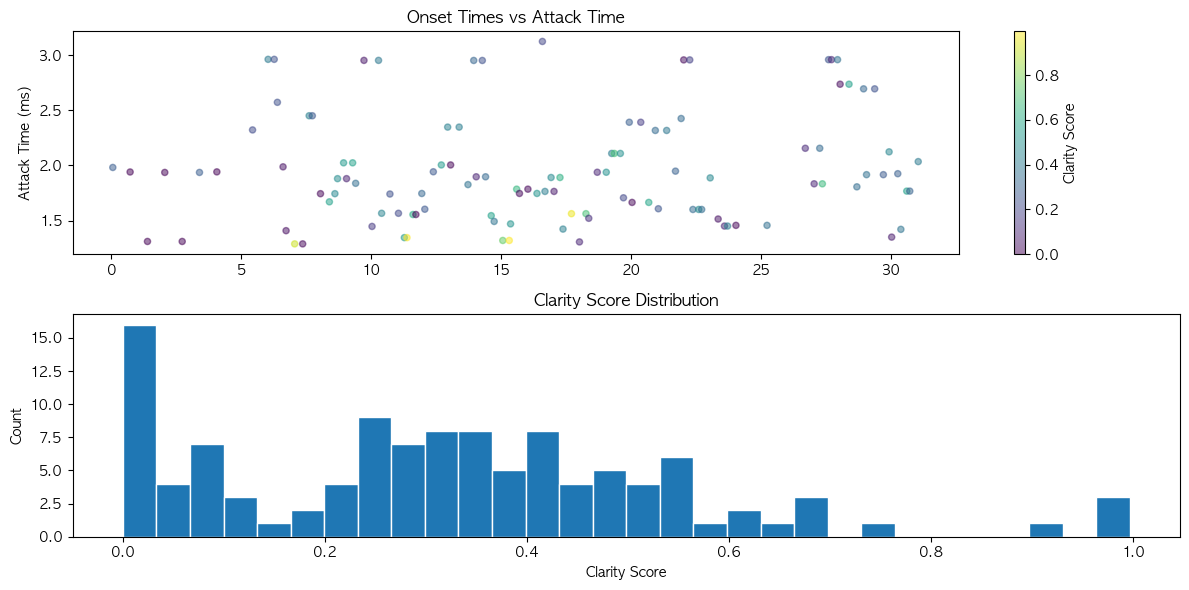

In [23]:
# 시각화
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.scatter(onset_times, attack_times, alpha=0.5, s=20, c=clarity_score, cmap='viridis')
plt.colorbar(label='Clarity Score')
plt.ylabel('Attack Time (ms)')
plt.title('Onset Times vs Attack Time')

plt.subplot(2, 1, 2)
plt.hist(clarity_score, bins=30, edgecolor='white')
plt.xlabel('Clarity Score')
plt.ylabel('Count')
plt.title('Clarity Score Distribution')

plt.tight_layout()
plt.show()

In [24]:
# JSON 내보내기
out = {
    "metadata": {
        "source": os.path.basename(audio_path),
        "sr": sr,
        "hop_length": int(hop_length),
        "bpm": round(float(bpm), 2),
        "total_events": len(onset_times)
    },
    "events": []
}

for i in range(len(onset_times)):
    out["events"].append({
        "index": i,
        "time": round(float(onset_times[i]), 4),
        "frame": int(onset_frames[i]),
        "strength": round(float(strengths[i]), 4),
        "attack_time_ms": round(float(attack_times[i]), 2),
        "clarity_score": round(float(clarity_score[i]), 4)
    })

samples_dir = os.path.join(project_root, "audio_engine", "samples")
os.makedirs(samples_dir, exist_ok=True)
json_path = os.path.join(samples_dir, "onset_events_clarity.json")

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

web_public = os.path.join(project_root, "web", "public")
if os.path.isdir(web_public):
    shutil.copy(json_path, os.path.join(web_public, "onset_events_clarity.json"))
    print(f"웹 public 복사 완료: web/public/onset_events_clarity.json")

print(f"저장 완료: {json_path}")

웹 public 복사 완료: web/public/onset_events_clarity.json
저장 완료: /Users/laxogud/MADCAMP/W4/music-anaylzer/audio_engine/samples/onset_events_clarity.json
